## session intialization

In [1]:
from pyspark.sql import SparkSession;
from pyspark.context import SparkContext
spark = SparkSession \
    .builder \
    .appName("Random_forest_regression") \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
spark

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [3]:
df = spark.read.csv('./data/Mall_Customers.csv',header=True, inferSchema=True)
df.show(5)

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
+----------+------+---+------------------+----------------------+
only showing top 5 rows



In [6]:
df.describe().show()

+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID|Gender|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  NULL|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  NULL|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



In [7]:
from pyspark.sql.functions import col, sum as spark_sum

missing_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Show the result
missing_counts.show()

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         0|     0|  0|                 0|                     0|
+----------+------+---+------------------+----------------------+



In [8]:
df = df.dropna(how='any')

In [9]:
missing_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Show the result
missing_counts.show()

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         0|     0|  0|                 0|                     0|
+----------+------+---+------------------+----------------------+



In [10]:
df.dtypes

[('CustomerID', 'int'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Annual Income (k$)', 'int'),
 ('Spending Score (1-100)', 'int')]

In [11]:
from pyspark.sql.types import StringType

def is_categorical(column):
    return isinstance(df.schema[column].dataType, StringType)

# Select only categorical columns
categorical_columns = [column for column in df.columns if is_categorical(column)]

In [12]:
categorical_columns

['Gender']

In [14]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer


In [15]:
indexed_df = df
for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_indexed')
    indexed_df = indexer.fit(indexed_df).transform(indexed_df)
    indexed_df = indexed_df.drop(col)
indexed_df.show()

+----------+---+------------------+----------------------+--------------+
|CustomerID|Age|Annual Income (k$)|Spending Score (1-100)|Gender_indexed|
+----------+---+------------------+----------------------+--------------+
|         1| 19|                15|                    39|           1.0|
|         2| 21|                15|                    81|           1.0|
|         3| 20|                16|                     6|           0.0|
|         4| 23|                16|                    77|           0.0|
|         5| 31|                17|                    40|           0.0|
|         6| 22|                17|                    76|           0.0|
|         7| 35|                18|                     6|           0.0|
|         8| 23|                18|                    94|           0.0|
|         9| 64|                19|                     3|           1.0|
|        10| 30|                19|                    72|           0.0|
|        11| 67|                19|   

In [16]:
df = indexed_df
df.dtypes

[('CustomerID', 'int'),
 ('Age', 'int'),
 ('Annual Income (k$)', 'int'),
 ('Spending Score (1-100)', 'int'),
 ('Gender_indexed', 'double')]

In [17]:
X = df.drop('Spending Score (1-100)')
Y = df.select('Spending Score (1-100)')

In [21]:
assembler = VectorAssembler(inputCols=X.columns, outputCol="features")
df = assembler.transform(df)

In [22]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
data_df = scaler_model.transform(df)

In [23]:
data_df.show(4)

+----------+---+------------------+----------------------+--------------+-------------------+--------------------+
|CustomerID|Age|Annual Income (k$)|Spending Score (1-100)|Gender_indexed|           features|     scaled_features|
+----------+---+------------------+----------------------+--------------+-------------------+--------------------+
|         1| 19|                15|                    39|           1.0|[1.0,19.0,15.0,1.0]|[0.01727736851162...|
|         2| 21|                15|                    81|           1.0|[2.0,21.0,15.0,1.0]|[0.03455473702325...|
|         3| 20|                16|                     6|           0.0|[3.0,20.0,16.0,0.0]|[0.05183210553488...|
|         4| 23|                16|                    77|           0.0|[4.0,23.0,16.0,0.0]|[0.06910947404650...|
+----------+---+------------------+----------------------+--------------+-------------------+--------------------+
only showing top 4 rows



In [24]:
wssse_values =[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,8):    
    KMeans_mod = KMeans(featuresCol='scaled_features', k=i)  
    KMeans_fit = KMeans_mod.fit(data_df)  
    output = KMeans_fit.transform(data_df)   
    score = evaluator.evaluate(output)   
    wssse_values.append(score)  
    print("Silhouette Score:",score)

Silhouette Score: 0.4747189171704767
Silhouette Score: 0.4815225535370972
Silhouette Score: 0.5210272385184719
Silhouette Score: 0.5541787478772321
Silhouette Score: 0.5459734127563838
Silhouette Score: 0.5748135159658847


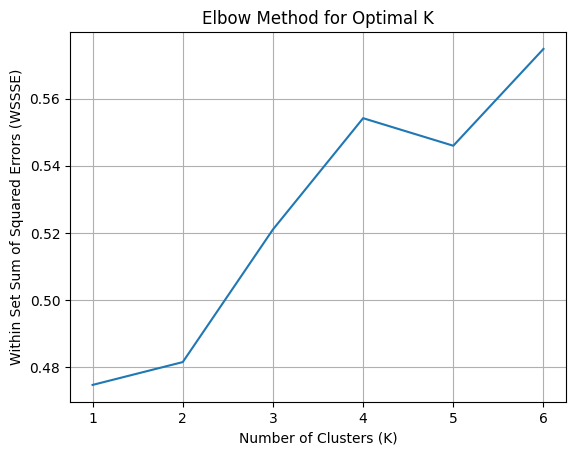

In [25]:
import matplotlib.pyplot as plt
plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()


In [26]:
kmeans = KMeans(k=4, featuresCol="scaled_features", predictionCol="cluster")
kmeans_model = kmeans.fit(data_df)

# Assigning the data points to clusters
clustered_data = kmeans_model.transform(data_df)

In [27]:
output = KMeans_fit.transform(data_df)
wssse = evaluator.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.5748135159658847
